### Voer in onderstaande codeblock de variabelen naar wens in:

Door onderstaande variabelen in te vullen wordt er na het draaien van de code de "Voorspelde kosten" gegeven voor de variabelen die er gezet zijn.

In [9]:
# inlees variabelen
beginJaarInlezen = 15 # 15 = 2015
eindJaarInlezen = 21  # 21 = 2021

# voorspellings variabelen
gemeente = 'AMSTERDAM' # moet in hoofdletters
leeftijd = 24
geslacht = 'M' # M of V
jaar = 2015
kosten_type = 'kosten_farmacie'
kosten_ziekenvervoer_liggend = 25957.00
kosten_medisch_specialistische_zorg = 1361637.19


In [10]:
geslacht = geslacht.replace('M', '0').replace('V', '1')

In [11]:
# Handige Jupyter magic
%config IPCompleter.greedy = True
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

def remove_outliers(df,columns,n_std):
    for col in columns:        
        mean = df[col].mean()
        sd = df[col].std()
        
        df = df[(df[col] <= mean+(n_std*sd))]
        
    return df

# data uitlezen
def read_vektis_data(dir, start, end):
    dfArray = []

    for i in range(start, end):
        df = pd.read_csv(f'{dir}/vektis_20{i}.csv', sep=';', dtype={'geslacht': str, 'gemeentenaam': str, 'jaar': float}, low_memory=False)
        df.columns = df.columns.str.lower()
        df['jaar'] = 2000 + i
        dfArray.append(df)

    return pd.concat(dfArray)

# Read the data - data van voor 2015 mist veel GGZ data en is dus weggelaten
df = read_vektis_data('./Vektis', 15, 21)

# Veel null waarden op kosten_eerstelijnsverblijf, dus die kolom droppen
df = df.drop(columns=['kosten_eerstelijnsverblijf'])

# if column kosten_gzsp is not null then concat kosten_gzsp and kosten_overig into kosten_overig
df['kosten_overig'] = df.apply(lambda row: row['kosten_gzsp'] if pd.notnull(row['kosten_gzsp']) else row['kosten_overig'], axis=1)
df = df.drop(columns=['kosten_gzsp', 'aantal_verzekerdejaren']).dropna()

df = remove_outliers(df, [kosten_type], 3) # verwijder outliers met een 3 standaard deviaties

df['geslacht'].replace(['M', 'V'], [0, 1], inplace=True)

for index, row in df.iterrows():
    if row['leeftijdsklasse'] == '90+':
        df.at[index, 'leeftijdsklasse'] = 90
    else:
        leeftijdArray = row['leeftijdsklasse'].strip().split(' ')
        
        # get the last number in leeftijdArray
        row['leeftijdsklasse'] = df.at[index, 'leeftijdsklasse'] = leeftijdArray[-1]

        if (row['leeftijdsklasse'] == 'jaar'):
             row['leeftijdsklasse'] = df.at[index, 'leeftijdsklasse'] = leeftijdArray[-2]

df.astype({'leeftijdsklasse': 'int32'}).dtypes

df = df[df['gemeentenaam'] == 'ZWOLLE']

In [12]:
# independent variable
X = np.concatenate((np.array(df['jaar']).reshape(-1, 1), np.array(df['leeftijdsklasse']).reshape(-1, 1), np.array(df['geslacht']).reshape(-1, 1)), axis=1)

# dependent variable
y = df[kosten_type]

jaren = np.arange(jaar,jaar + 10,1)

poly_features = PolynomialFeatures(degree=2)  # You can adjust the degree as per your requirement
X_poly = poly_features.fit_transform(X)
model = LinearRegression()
model.fit(X_poly, y)

def predictCost(leeftijd, jaar, geslacht):
    leeftijdArray = np.array([leeftijd]).reshape(-1, 1)
    jaarArray = np.array([jaar]).reshape(-1, 1)
    geslachtArray= np.array([geslacht]).reshape(-1, 1)

    new_data = np.concatenate((jaarArray, leeftijdArray, geslachtArray), axis=1)
    new_data_poly = poly_features.transform(new_data)
    predicted_costs = model.predict(new_data_poly)

    return predicted_costs[0]

predicted_costs_list = [predictCost(leeftijd, jaar, geslacht) for jaar in jaren]

for pcl in predicted_costs_list:
    print(f"Voorspelde kosten {kosten_type}: {pcl}")
    print("---")



Voorspelde kosten kosten_farmacie: 441808.0414276123
---
Voorspelde kosten kosten_farmacie: 430598.4344100952
---
Voorspelde kosten kosten_farmacie: 438147.4197463989
---
Voorspelde kosten kosten_farmacie: 464454.99744415283
---
Voorspelde kosten kosten_farmacie: 509521.16750335693
---
Voorspelde kosten kosten_farmacie: 573345.92993927
---
Voorspelde kosten kosten_farmacie: 655929.2847442627
---
Voorspelde kosten kosten_farmacie: 757271.2319107056
---
Voorspelde kosten kosten_farmacie: 877371.7714538574
---
Voorspelde kosten kosten_farmacie: 1016230.9033432007
---


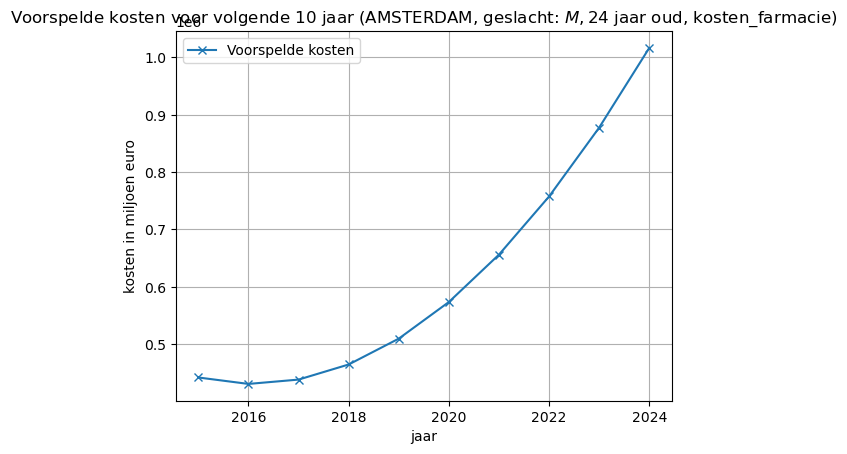

In [13]:
# Plotting the line chart
plt.plot(jaren, predicted_costs_list, label='Voorspelde kosten', marker='x')

stringGeslacht = geslacht.replace('0', 'M').replace('0', 'V')

# Adding labels and title
plt.xlabel('jaar')
plt.ylabel('kosten in miljoen euro')
plt.title(f'Voorspelde kosten voor volgende 10 jaar ({gemeente}, geslacht: ${stringGeslacht}, ${leeftijd} jaar oud, {kosten_type})')
plt.grid(True)

# Adding a legend
plt.legend()

# Displaying the plot
plt.show()